<a href="https://colab.research.google.com/github/LFBJC/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LEITURA DA BASE DE DADOS E DEFINIÇÃO DE ALGUMAS VARIÁVEIS GLOBAIS

In [1]:
#codigo baseado no primeiro curso da serie GANs for good
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from tqdm.auto import tqdm
import copy

#DEFINIÇÃO DE VARIÁVEIS
device = 'cuda' #dispositivo no qual o programa será executado (cuda para rodar em GPU ou cpu para rodar no processador)

#definição da GAN
z_dim = 64 #dimensão do vetor de entrada do gerador
gen_layers=1 #camadas do gerador
crit_layers=2 #camadas do critico
c_lambda = 10 #usado na função de perda do critico

#treinamento
crit_repeats = 5 #numero de vezes que o critico repete por epoca antes do gerador treinar
n_epochs = 100 #numero de epocas
batch_size = 128 #tamanho do batch
display_step = 50 #numero de passos até a exibição

#otimizadores
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

#geração controlável
#...

#leitura da base de dados
#transformação a ser aplicada na base de dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
#armazena os batches numa variável
batches = [b for b in DataLoader(
            MNIST('.', download=True, transform=transform),
            batch_size=batch_size,
            shuffle=True)]
'''
#os rotulos serao usados no classificador da geração controlável, mas é bom que seja com 
#algumas modificações porque faz mais sentido caracteristicas em vez de labels
labels = [b[1] for b in bartches]
labels = torch.tensor(labels).to(device)'''
batches = [b[0] for b in batches]
im_shape = tuple(batches[0][0].shape)
#print(labels)

#DEFINIÇÃO E TREINAMENTO DA GAN

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
#comentei a função abaixo porque não vi onde ela era utilizada, mas está no código do curso,
#deve ser usada numa parte mais pra frente, mas eu vou descobrir
'''
def make_grad_hook():
    #Function to keep track of gradients for visualization purposes, 
    #which fills the grads list when using model.apply(grad_hook).
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook'''

'\ndef make_grad_hook():\n    #Function to keep track of gradients for visualization purposes, \n    #which fills the grads list when using model.apply(grad_hook).\n    grads = []\n    def grad_hook(m):\n        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):\n            grads.append(m.weight.grad)\n    return grads, grad_hook'

In [3]:
##Definição do Gerador
class Generator(nn.Module):
  def __init__(self,z_dim,n_layers,im_shape):
    super(Generator, self).__init__()
    self.z_shape=(z_dim,1,1)
    self.gen = nn.Sequential()

    #para ajudar a calcular as dimensoes internas
    size_step = tuple([(i-z)//n_layers for i,z in zip(im_shape[1:],self.z_shape[1:])])
    chan_diff = (im_shape[0]-self.z_shape[0]) #checar a diferença dos canais para chegar nos canais de saida interpolando (faz mais sentido)

    #criação das camadas do modelo
    input_shape=self.z_shape
    in_ch = z_dim
    output_shape=(0,0,0)
    for i in range(n_layers-1):
      delta_ch = (chan_diff//n_layers) if (chan_diff>0) else -(-chan_diff//n_layers) 
      out_ch=in_ch + delta_ch
      output_shape = [out_ch]
      output_shape.extend([i+s for i,s in zip(input_shape[1:],size_step)])
      output_shape = tuple(output_shape)
      self.gen.add_module(str(i),self.make_gen_block(input_shape,output_shape))
      input_shape=output_shape
      in_ch=out_ch
    self.gen.add_module(str(n_layers-1),self.make_gen_block(input_shape,im_shape,last_layer=True))

  def make_gen_block(self,in_shape,out_shape,stride=1,last_layer=False):
    input_channels,h_in,w_in = in_shape
    output_channels,h_out,w_out = out_shape
    kernel_size=(h_out-stride*(h_in-1),w_out-stride*(w_in-1))
    if last_layer:
      return nn.Sequential(nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                           nn.Tanh())
    else:
      return nn.Sequential(nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                           nn.BatchNorm2d(output_channels),
                           nn.ReLU(inplace=True))
      
  def forward(self,noise):
    n_samples = len(noise)
    return self.gen(noise.view(n_samples,*self.z_shape)) #o ruido é passado como uma imagem em forma de coluna

def get_noise(n_samples,z_dim,device='cpu'):
  return torch.randn((n_samples,z_dim),device=device)
  
##Definição do Crítico
class Critic(nn.Module):
  def __init__(self,n_layers,im_shape):
    super(Critic, self).__init__()
    self.crit = nn.Sequential()

    #para ajudar a calcular as dimensoes internas
    size_step = tuple([(i-1)//n_layers for i in im_shape[1:]])
    chan_diff = (im_shape[0]-1) #checar a diferença dos canais para chegar nos canais de saida interpolando (faz mais sentido)

    #criação das camadas do modelo
    input_shape=im_shape
    in_ch = im_shape[0]
    output_shape=(0,0,0)
    for i in range(n_layers-1):
      delta_ch = (chan_diff//n_layers) if (chan_diff>0) else -(-chan_diff//n_layers) 
      out_ch=in_ch - delta_ch
      output_shape = [out_ch]
      output_shape.extend([i-s for i,s in zip(input_shape[1:],size_step)])
      output_shape = tuple(output_shape)
      self.crit.add_module(str(i),self.make_crit_block(input_shape,output_shape))
      input_shape=output_shape
      in_ch=out_ch
    self.crit.add_module(str(n_layers-1),self.make_crit_block(input_shape,(1,1,1),last_layer=True))

  def make_crit_block(self,in_shape,out_shape,stride=1,last_layer=False):
    input_channels,h_in,w_in = in_shape
    output_channels,h_out,w_out = out_shape
    kernel_size=(h_in-stride*(h_out-1),w_in-stride*(w_out-1))
    if last_layer:
      return nn.Sequential(nn.Conv2d(input_channels,output_channels,kernel_size,stride))
    else:
      return nn.Sequential(nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                           nn.BatchNorm2d(output_channels),
                           nn.LeakyReLU(0.2,inplace=True))
  def forward(self,image):
    return self.crit(image)

In [4]:
gen = Generator(z_dim,gen_layers,im_shape).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic(crit_layers,im_shape).to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [5]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm-torch.ones_like(gradient_norm))**2)
    return penalty

In [6]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    return -torch.mean(crit_fake_pred)
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    return -(torch.mean(crit_real_pred)-torch.mean(crit_fake_pred))+gp*c_lambda

##TREINAMENTO

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 50: Generator loss: 0.050276330262422564, critic loss: 4.226507907748221


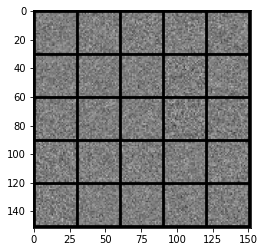

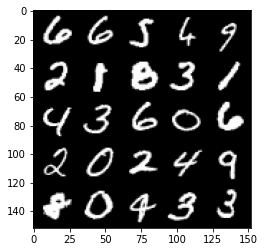

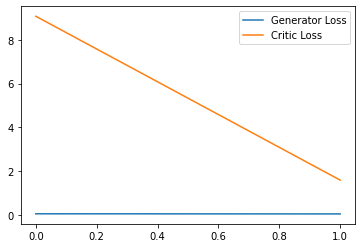

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 100: Generator loss: 0.05820384170860052, critic loss: 0.8957348613739016


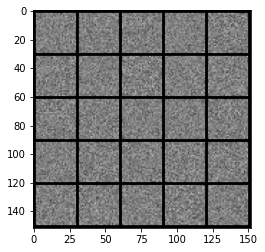

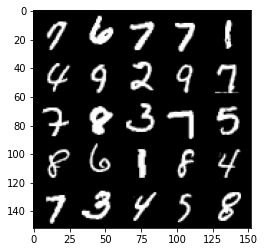

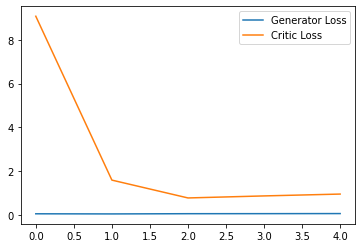

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 150: Generator loss: 0.056193083319813014, critic loss: 0.9586140236854556


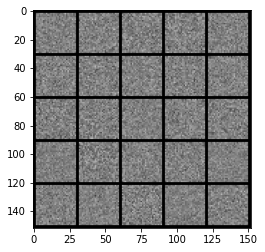

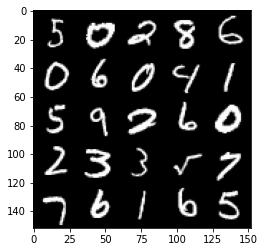

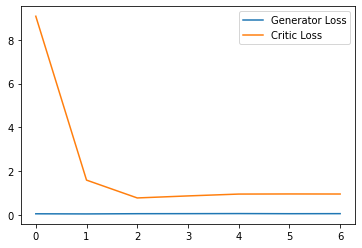

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 200: Generator loss: 0.06914416141342372, critic loss: 0.909479517221451


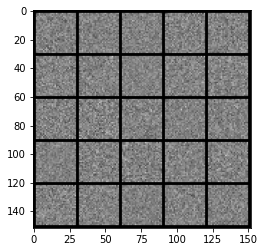

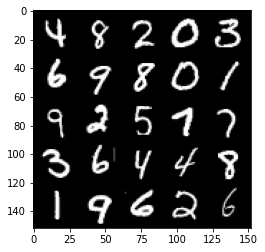

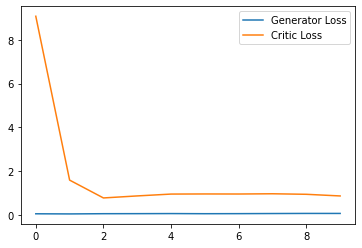

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 250: Generator loss: 0.06659311067312956, critic loss: 0.766492939591408


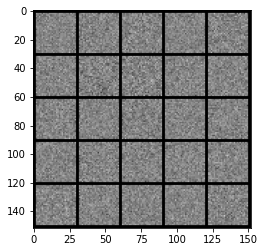

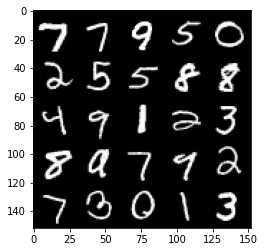

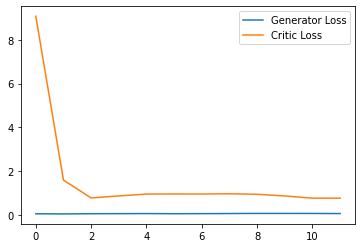

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 300: Generator loss: 0.06156710613518954, critic loss: 0.7212864091396333


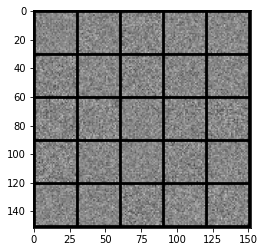

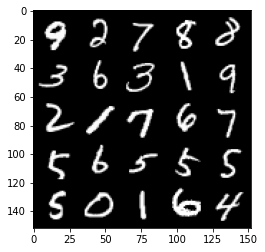

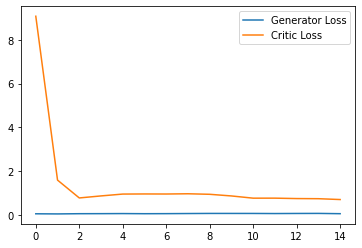

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 350: Generator loss: 0.061580409146845344, critic loss: 0.6791867533922198


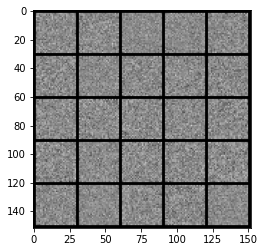

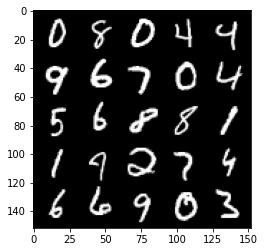

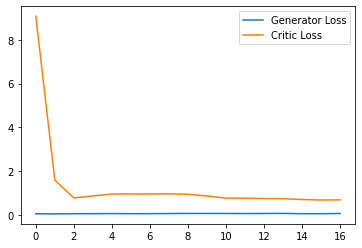

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 400: Generator loss: 0.053590022437274454, critic loss: 0.6503362133502961


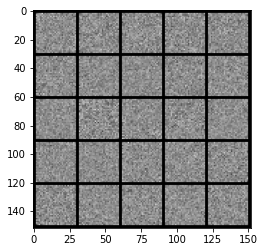

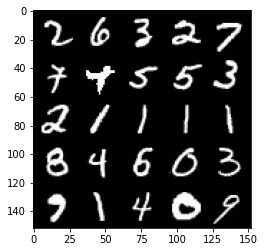

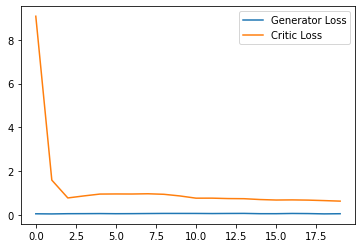

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 450: Generator loss: 0.05276671590283513, critic loss: 0.5704195889830591


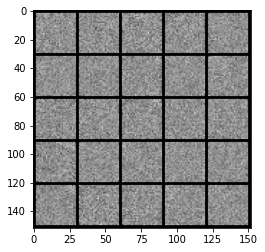

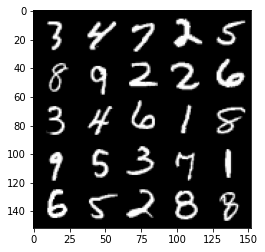

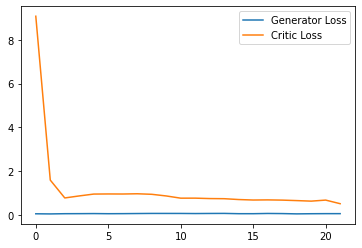

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 500: Generator loss: 0.03542384572327137, critic loss: 0.32930279091000547


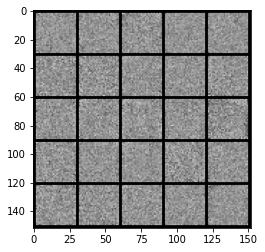

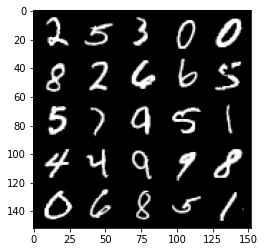

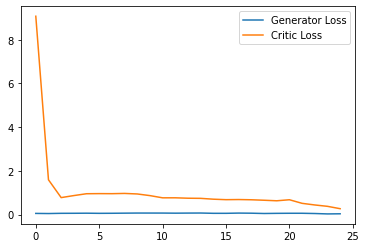

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 550: Generator loss: -0.010343931932002306, critic loss: 0.18099942836165425


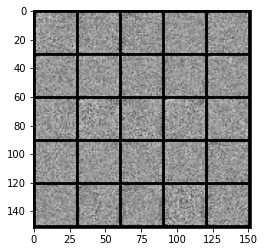

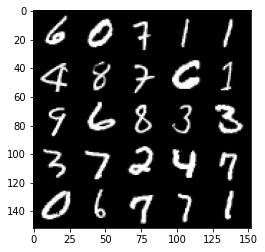

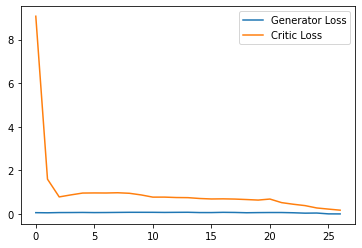

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 600: Generator loss: -0.06433487471193075, critic loss: 0.13077557927370068


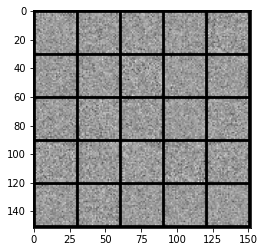

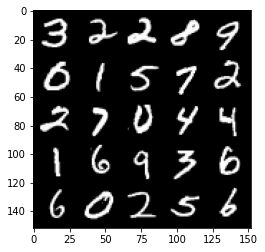

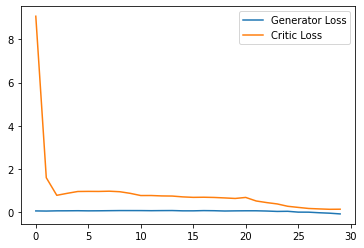

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 650: Generator loss: -0.14642390564084054, critic loss: 0.1446777339279652


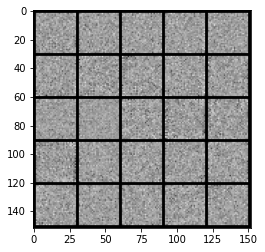

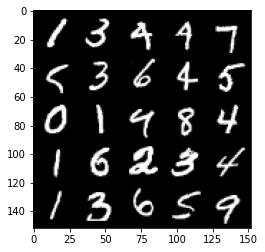

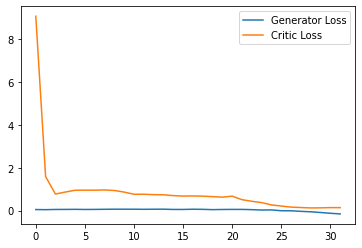

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 700: Generator loss: -0.19767425924539567, critic loss: 0.17110077977180482


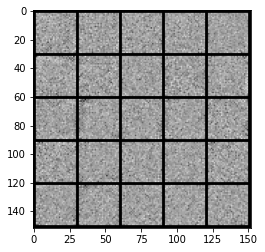

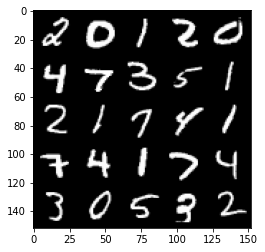

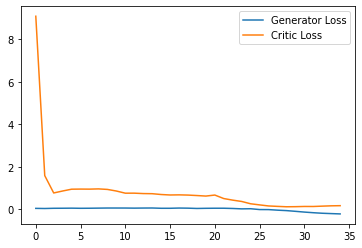

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 750: Generator loss: -0.22940835237503052, critic loss: 0.18472516125440602


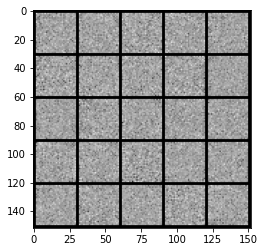

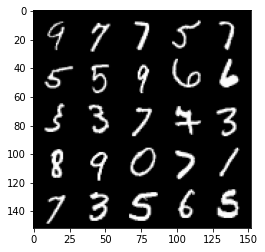

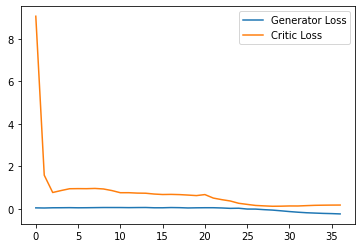

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 800: Generator loss: -0.24829000532627105, critic loss: 0.18865129125118255


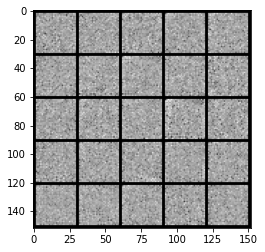

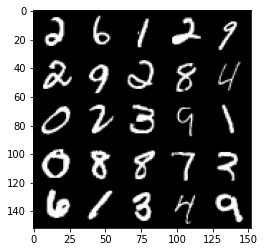

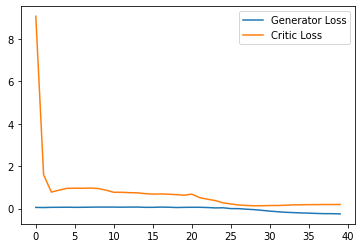

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 850: Generator loss: -0.27927338182926176, critic loss: 0.21175689870119085


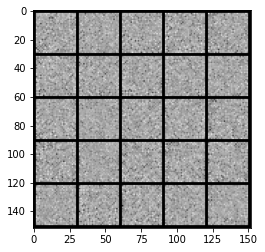

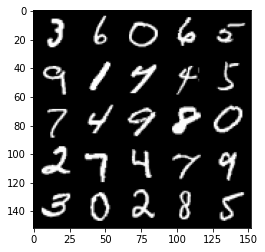

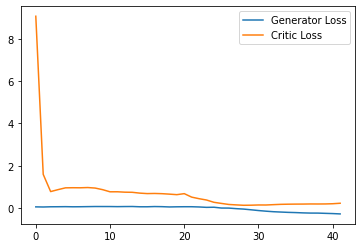

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 900: Generator loss: -0.32306615948677064, critic loss: 0.23540500301122658


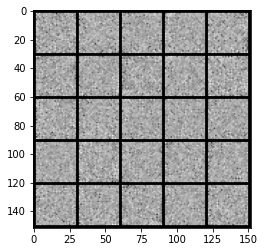

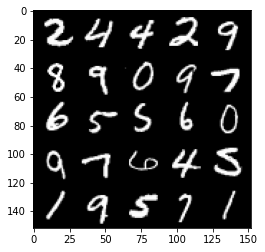

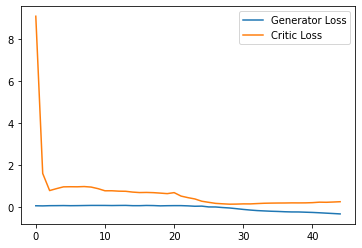

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 950: Generator loss: -0.37802348971366884, critic loss: 0.27150210428237914


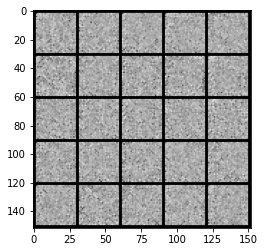

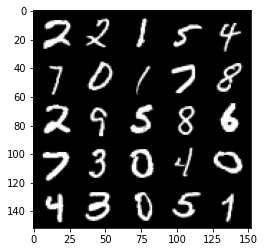

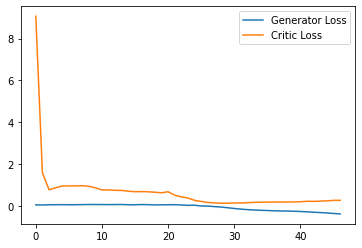

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1000: Generator loss: -0.4284106695652008, critic loss: 0.30431829231977464


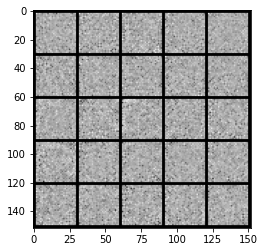

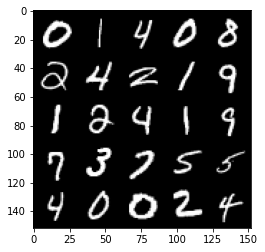

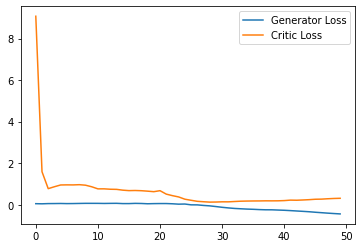

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1050: Generator loss: -0.4513121956586838, critic loss: 0.29296360397338866


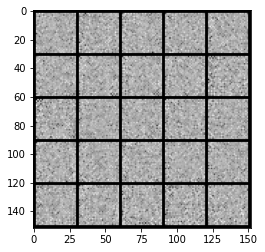

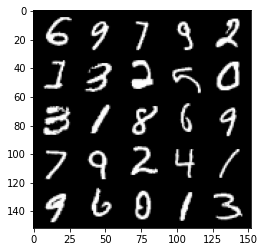

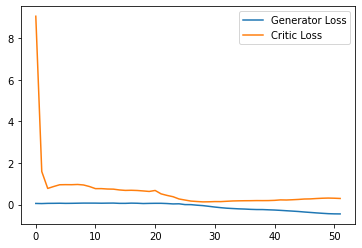

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1100: Generator loss: -0.3646150478720665, critic loss: 0.1527571041509509


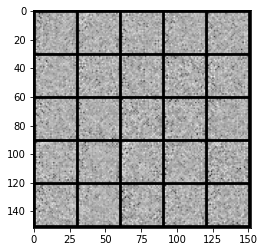

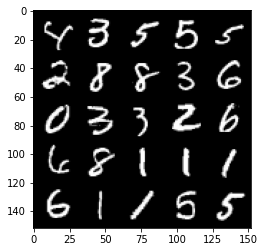

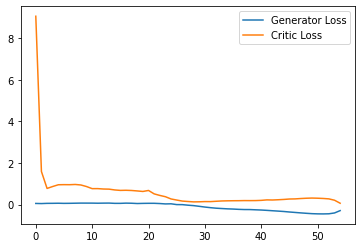

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1150: Generator loss: -0.11346511766314507, critic loss: -0.19124321500957017


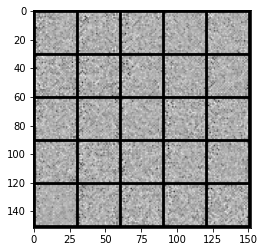

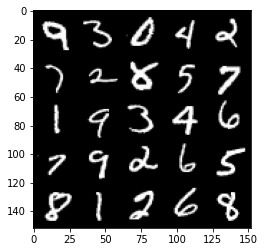

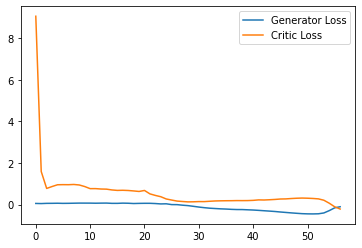

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1200: Generator loss: 0.017740271240472793, critic loss: 0.0664208859205246


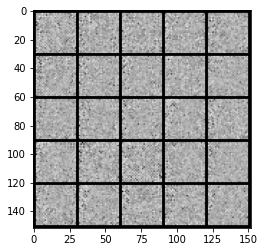

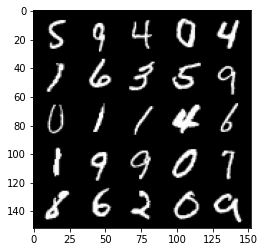

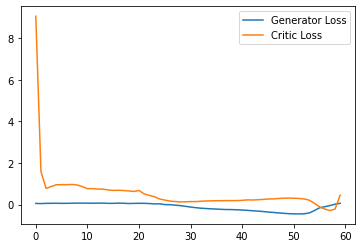

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1250: Generator loss: -0.3198867615312338, critic loss: 2.0698166117668153


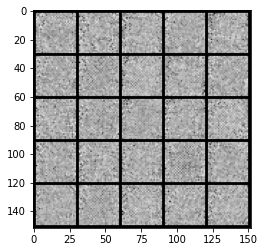

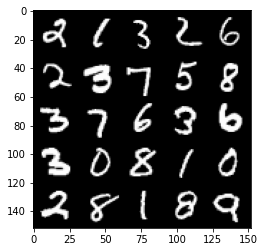

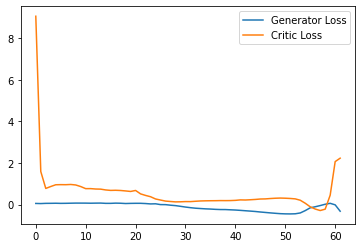

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1300: Generator loss: -1.6346335220336914, critic loss: -0.2705712580680848


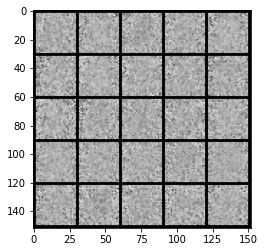

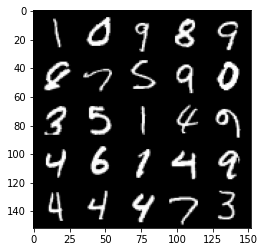

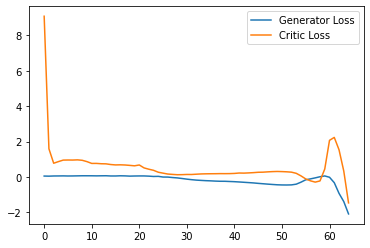

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1350: Generator loss: -2.2272705602645875, critic loss: -4.179091795921326


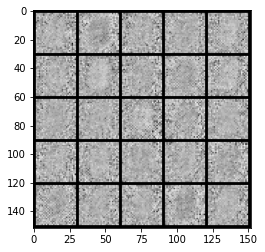

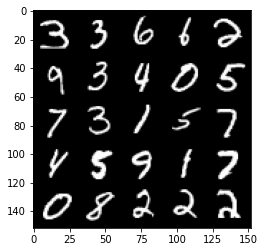

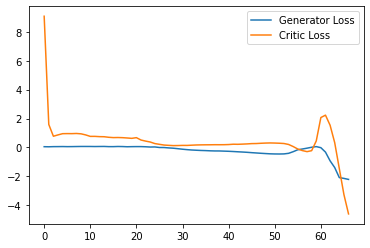

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1400: Generator loss: -1.4746148633956908, critic loss: -6.533759607315063


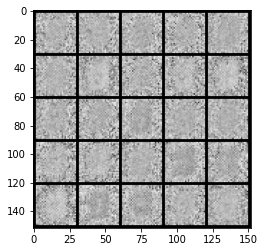

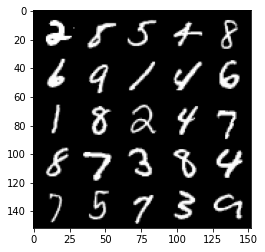

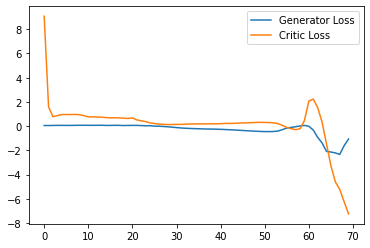

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1450: Generator loss: -0.3216227014362812, critic loss: -8.0858239364624


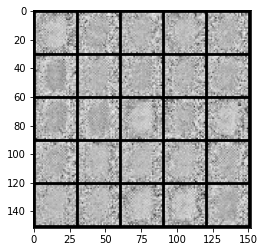

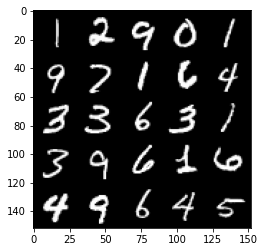

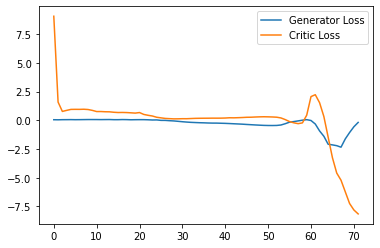

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1500: Generator loss: 0.5975198574364186, critic loss: -9.053025251388549


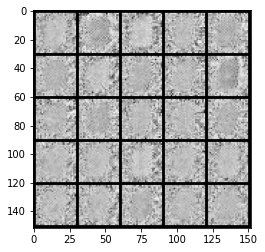

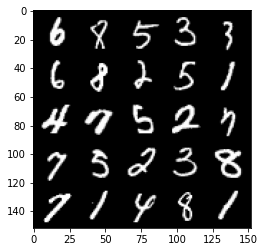

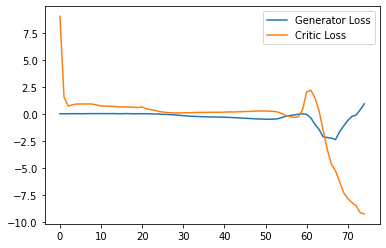

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1550: Generator loss: 1.1730492985248566, critic loss: -9.622292676925658


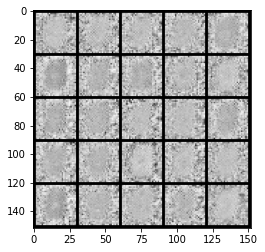

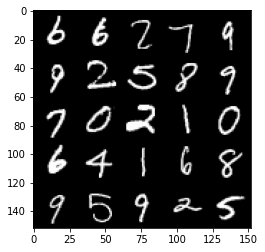

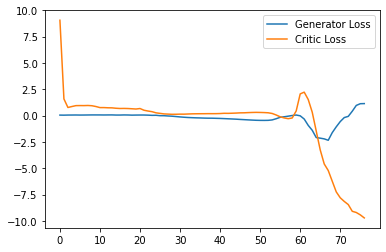

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1600: Generator loss: 1.6518035995960236, critic loss: -9.808251289367677


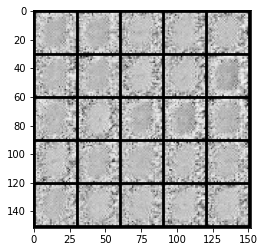

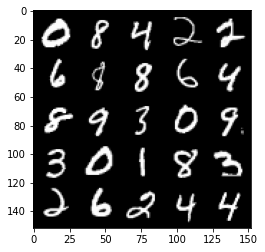

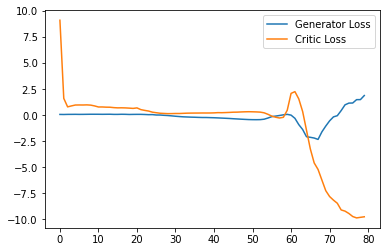

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1650: Generator loss: 1.7696523231267929, critic loss: -9.91200471687317


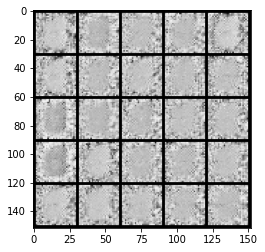

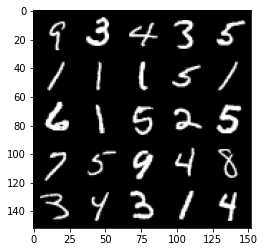

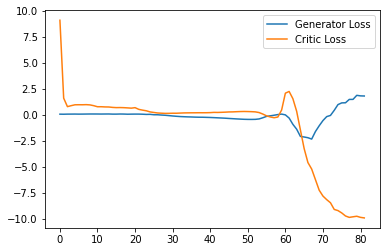

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1700: Generator loss: 1.3830544447898865, critic loss: -9.82076341056824


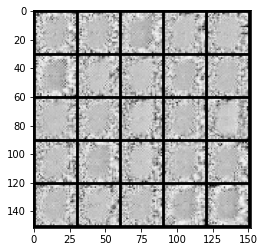

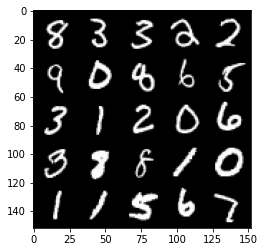

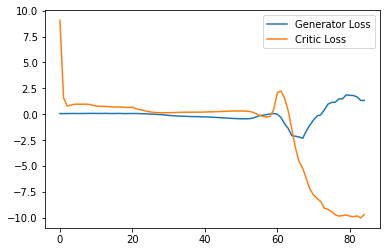

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1750: Generator loss: 1.0287806648015976, critic loss: -9.232404388427735


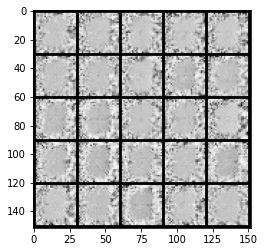

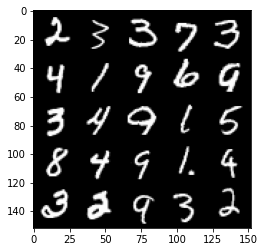

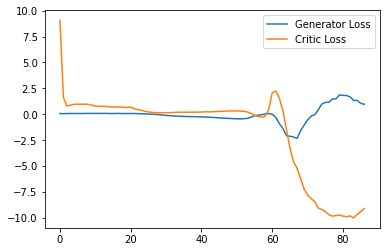

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1800: Generator loss: 0.45462669909000397, critic loss: -8.869076137542725


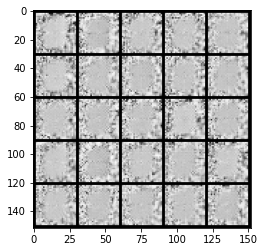

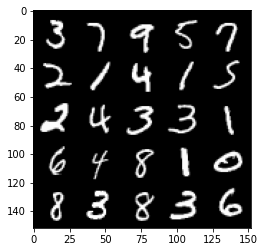

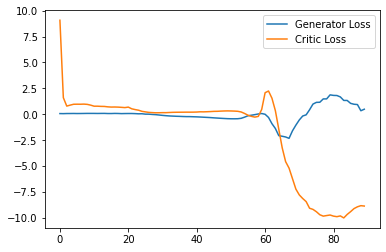

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1850: Generator loss: 0.4670432409644127, critic loss: -8.775519292831422


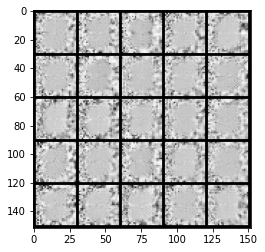

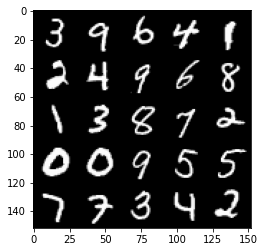

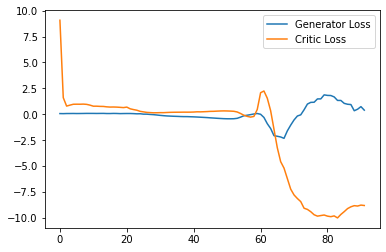

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1900: Generator loss: 0.12990592211484908, critic loss: -8.316508766174316


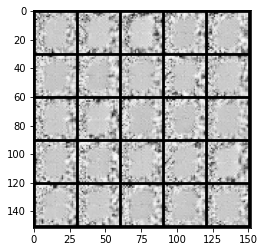

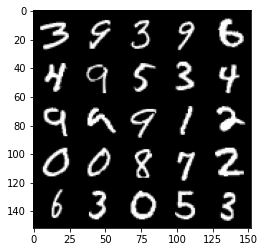

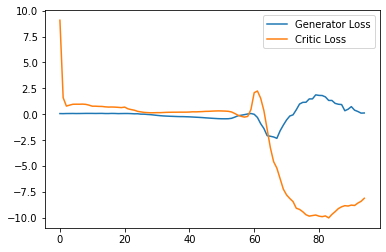

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step 1950: Generator loss: -0.3437732245028019, critic loss: -8.03526020812988


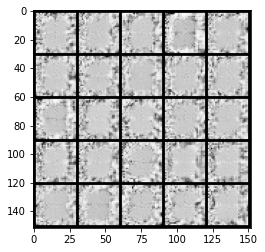

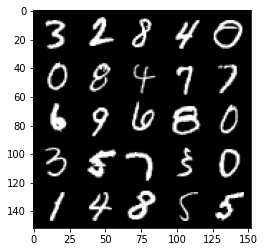

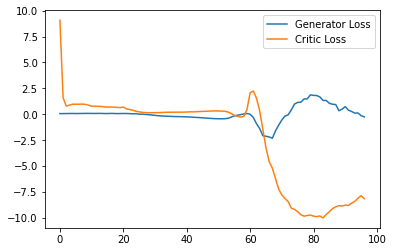

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    for real in tqdm(batches):
        cur_batch_size = len(real)
        real = torch.tensor(real).to(device)
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise).detach()
            crit_fake_pred = crit(fake)
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]
        
        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
gen.eval()
crit.eval()

#CLASSIFICADOR PARA A GERAÇÃO CONTROLÁVEL

In [ ]:
#Classificador para geração controlável
'''
Classifier_layers = list(copy.deepcopy(crit).children())[:-1]
Classifier = nn.Sequential(*Classifier_layers,#colocar camada de saida)
classif_opt = torch.optim.Adam(Classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
classif_loss = nn.MSE_loss()'''

In [ ]:
#Treinar o classificador
#só quando ele estiver pronto - modificar camada de saída e descomentar
'''
epochs_classifier = 20
targets = [labels[i,i+batch_size] for i in range(0,len(images),batch_size)]
losses = []
for epoch in range(epochs_classifier):
  for i in range(len(batches)):
    x, y = batches[i].to(device), targets[i].to(device)
    classif_opt.zero_grad()
    y_hat = Classifier(x)
    loss = classif_loss(y,y_hat)
    loss.backward()
    classif_opt.step()
    losses += [loss.item()]
step_bins = 20
num_examples = (len(losses) // step_bins) * step_bins
plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Classifier Loss"
            )
plt.legend()
plt.show()'''

#GERAÇÃO CONTROLÁVEL

In [ ]:
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    new_noise = noise + weight*noise.grad
    return new_noise

In [ ]:
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization
target_indices = 0
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)